# Cell segmentation

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '/mnt/c/Users/phoen/Documents/GitHub/spateo-release')

import gzip

import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st
from scipy import ndimage

plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

/home/lioscro/miniconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/lioscro/miniconda3/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


## Load the data

In [2]:
tif = skimage.io.imread('data/SS200000135IL-D1.ssDNA.tif')
total, exonic, intronic = st.io.read_bgi_agg('data/SS200000135TL_D1_all_bin1.txt.gz')

# Binned to 10x10 -- these are used for density-based segmentation at the end of this tutorial
total_bin, exonic_bin, intronic_bin = st.io.read_bgi_agg('data/SS200000135TL_D1_all_bin1.txt.gz', binsize=10)

with gzip.open('data/SS200000135IL_nuclei_labels.npz.gz', 'r') as f:
    nuclei_labels = np.load(f)
with gzip.open('data/SS200000135TL_nuclei_labels.npz.gz', 'r') as f:
    est_nuclei_labels = np.load(f)
with gzip.open('data/SS200000135TL_nuclei_density_labels.npz.gz', 'r') as f:
    est_density_nuclei_lables = np.load(f)

Text(0.5, 1.0, 'intronic')

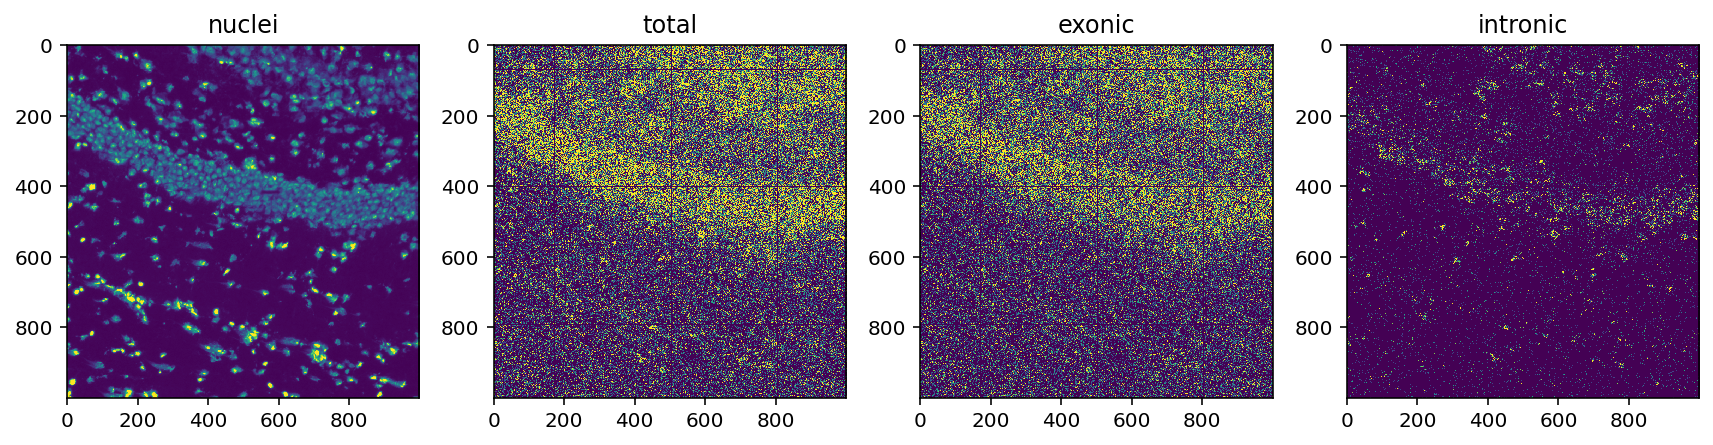

In [210]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')
axes[1].imshow(total.A, vmin=0, vmax=5)
axes[1].set_title('total')
axes[2].imshow(exonic.A, vmin=0, vmax=5)
axes[2].set_title('exonic')
axes[3].imshow(intronic.A, vmin=0, vmax=5)
axes[3].set_title('intronic')

## Using nucleus staining results

Text(0.5, 1.0, 'cell segmentation')

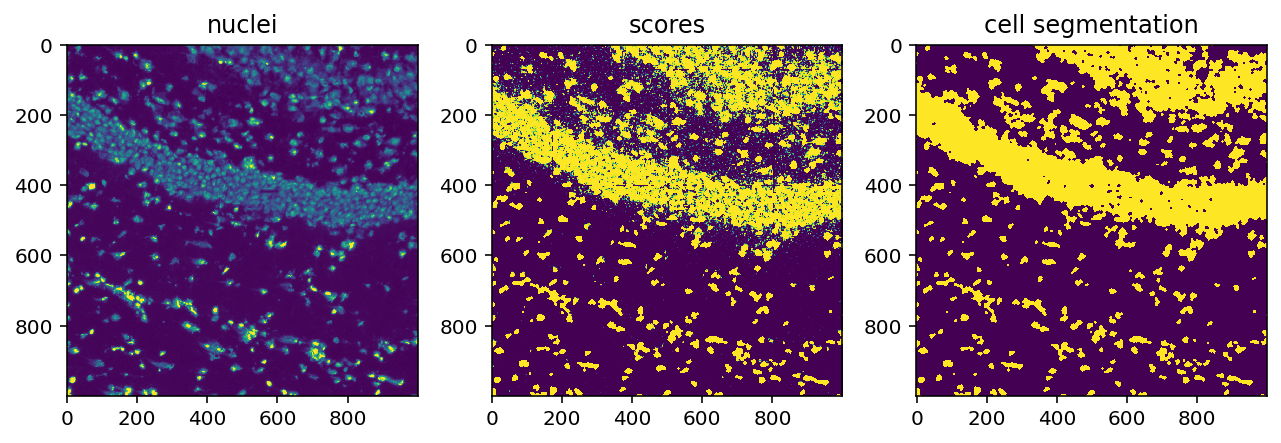

In [211]:
scores = st.pp.segmentation.icell.score_pixels(
    total,
    k=5,
    method='EM+BP',
    em_kwargs=dict(downsample=100000, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=2 / 3, q=1 / 3),
    certain_mask=nuclei_labels > 0
)
thresholds = skimage.filters.threshold_multiotsu(scores, classes=3)
cell_mask = st.pp.segmentation.utils.apply_threshold(scores, 7, thresholds[1])

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(scores)
axes[1].set_title('scores')

axes[2].imshow(cell_mask)
axes[2].set_title('cell segmentation')

Text(0.5, 1.0, 'enlarged')

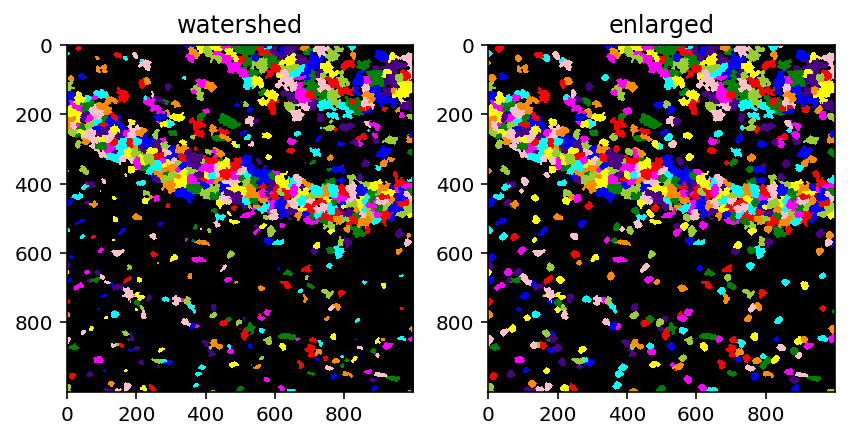

In [212]:
watershed = st.pp.segmentation.label.watershed(total, cell_mask, nuclei_labels, 11)
enlarged = st.pp.segmentation.label.expand_labels(watershed, 5, 400)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(skimage.color.label2rgb(watershed))
axes[0].set_title('watershed')

axes[1].imshow(skimage.color.label2rgb(enlarged))
axes[1].set_title('enlarged')

In [213]:
with gzip.open('data/SS200000135IL_cell_labels.npz.gz', 'w') as f:
    np.save(f, enlarged)

## Using RNA-based nucleus segmentation results

Text(0.5, 1.0, 'cell segmentation')

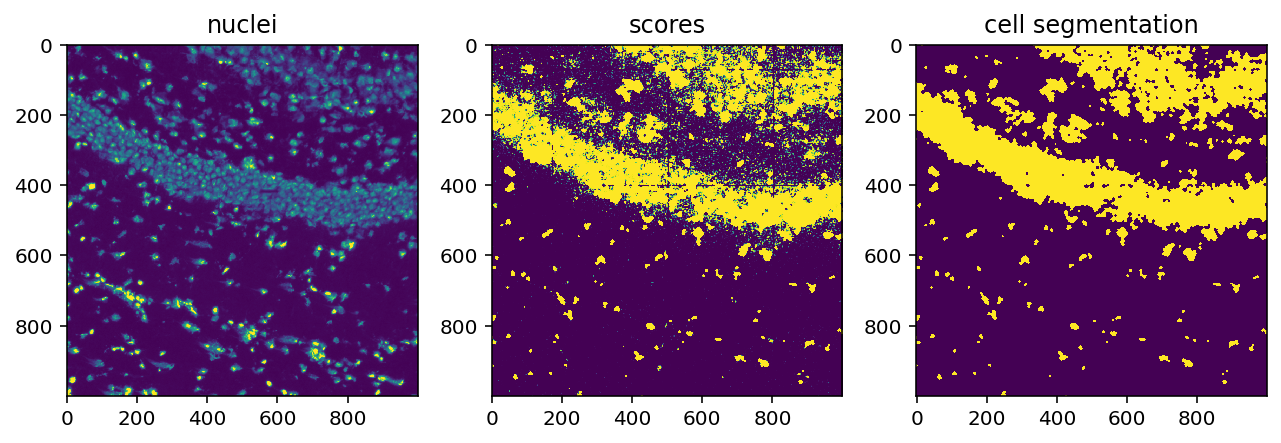

In [214]:
scores = st.pp.segmentation.icell.score_pixels(
    total,
    k=5,
    method='EM+BP',
    em_kwargs=dict(downsample=100000, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=2 / 3, q=1 / 3),
    certain_mask=est_nuclei_labels > 0
)
thresholds = skimage.filters.threshold_multiotsu(scores, classes=3)
est_cell_mask = st.pp.segmentation.utils.apply_threshold(scores, 7, thresholds[1])

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(scores)
axes[1].set_title('scores')

axes[2].imshow(est_cell_mask)
axes[2].set_title('cell segmentation')

Text(0.5, 1.0, 'enlarged')

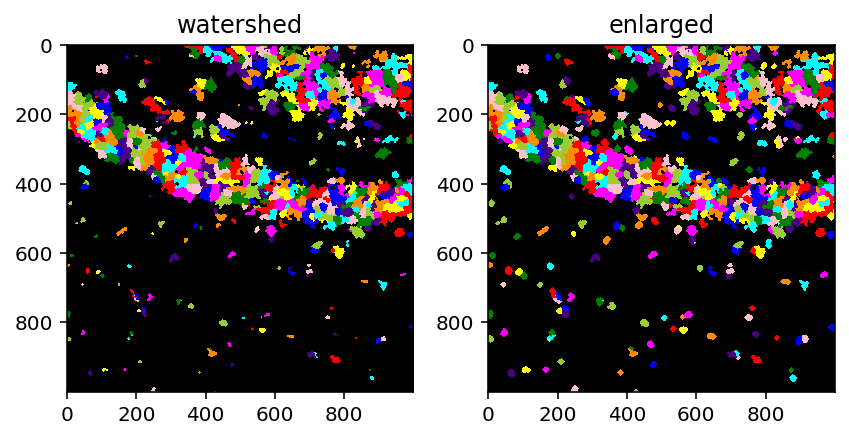

In [215]:
est_watershed = st.pp.segmentation.label.watershed(total, est_cell_mask, nuclei_labels, 11)
est_enlarged = st.pp.segmentation.label.expand_labels(est_watershed, 5, 400)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(skimage.color.label2rgb(est_watershed))
axes[0].set_title('watershed')

axes[1].imshow(skimage.color.label2rgb(est_enlarged))
axes[1].set_title('enlarged')

In [216]:
with gzip.open('data/SS200000135TL_cell_labels.npz.gz', 'w') as f:
    np.save(f, est_enlarged)

## Using RNA-based nucleus segmentation results with density

Text(0.5, 1.0, 'UMI density clusters')

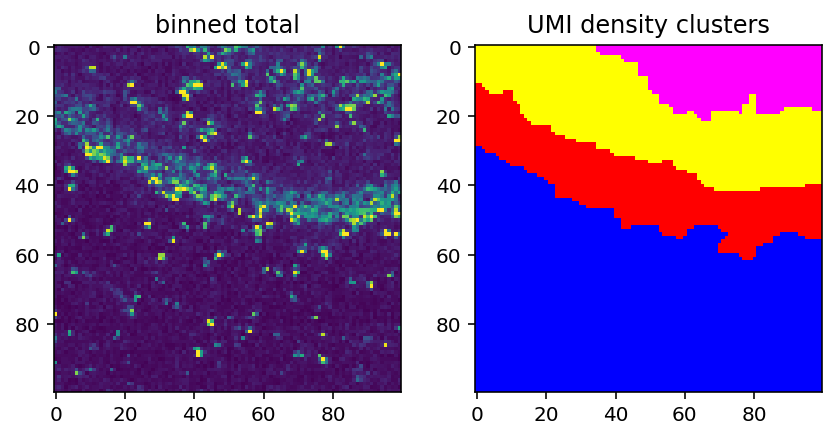

In [243]:
bins = st.pp.segmentation.segment_densities(total_bin, 5, distance_threshold=4)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(intronic_bin.A, vmin=0, vmax=200)
axes[0].set_title('binned total')
axes[1].imshow(skimage.color.label2rgb(bins))
axes[1].set_title('UMI density clusters')

Text(0.5, 1.0, 'cell segmentation')

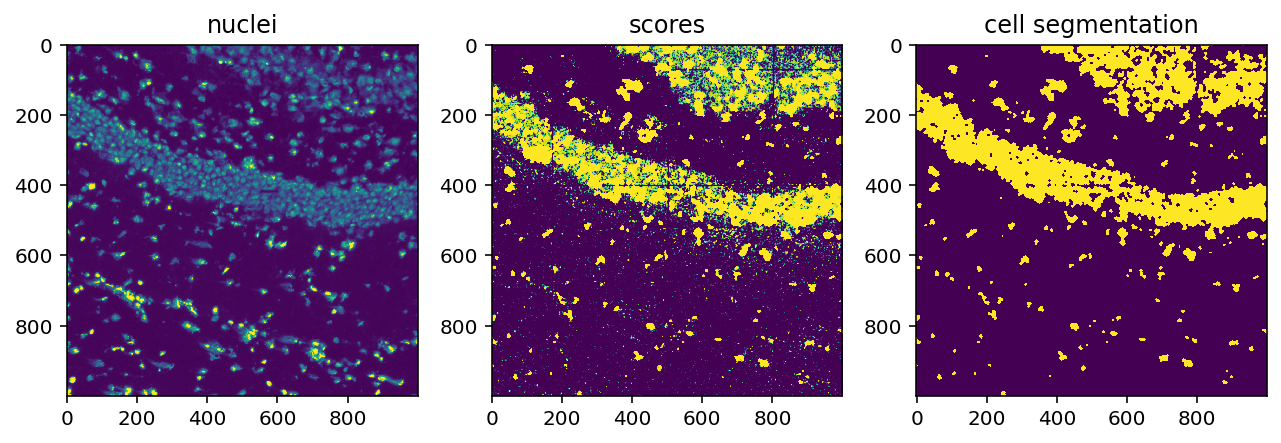

In [244]:
scores = st.pp.segmentation.icell.score_pixels(
    total,
    k=5,
    method='EM+BP',
    em_kwargs=dict(downsample=100000, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=2 / 3, q=1 / 3),
    certain_mask=est_density_nuclei_lables > 0,
    bins=cv2.resize(bins, (1000, 1000), interpolation=cv2.INTER_NEAREST),
)

thresholds = skimage.filters.threshold_multiotsu(scores, classes=3)
est_density_cell_mask = st.pp.segmentation.utils.apply_threshold(scores, 7, thresholds[1])

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(scores)
axes[1].set_title('scores')

axes[2].imshow(est_density_cell_mask)
axes[2].set_title('cell segmentation')

Text(0.5, 1.0, 'enlarged')

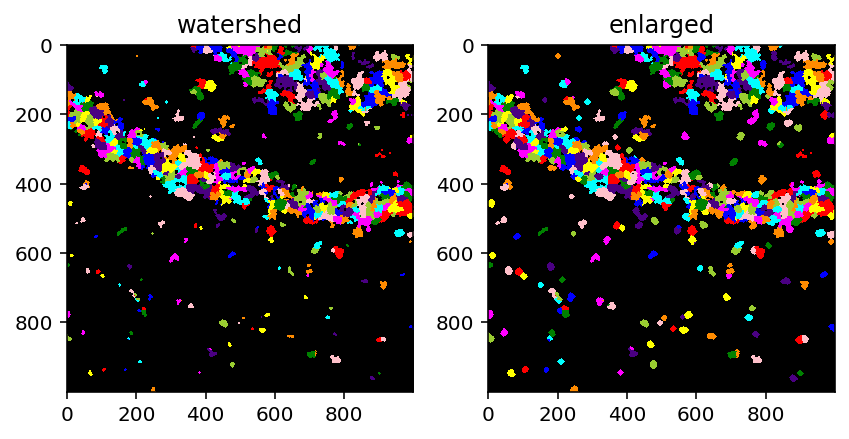

In [232]:
est_density_watershed = st.pp.segmentation.label.watershed(total, est_density_cell_mask, nuclei_labels, 11)
est_density_enlarged = st.pp.segmentation.label.expand_labels(est_density_watershed, 5, 400)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(skimage.color.label2rgb(est_density_watershed))
axes[0].set_title('watershed')

axes[1].imshow(skimage.color.label2rgb(est_density_enlarged))
axes[1].set_title('enlarged')

In [233]:
with gzip.open('data/SS200000135TL_cell_density_labels.npz.gz', 'w') as f:
    np.save(f, est_density_enlarged)

## Performance benchmarks

How consistent are the cell labelings between those obtained from stained nuclei and those from RNA-based nucleus segmentation? The metrics shown here are the same with those in `nuclei_segmentation.ipynb`.

Text(0.5, 1.0, 'RNA mask with density')

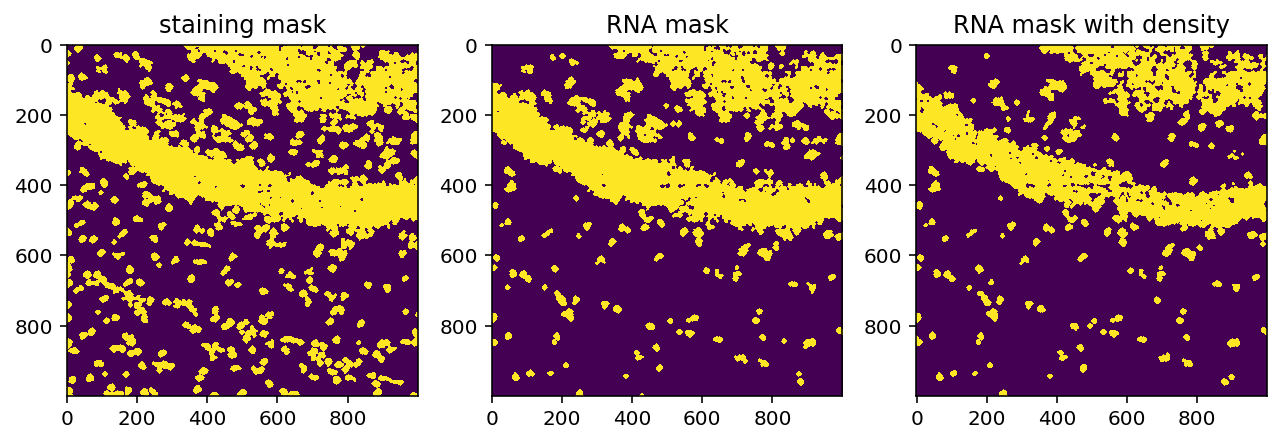

In [234]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
enlarged_mask = enlarged > 0
est_enlarged_mask = est_enlarged > 0
est_density_enlarged_mask = est_density_enlarged > 0

axes[0].imshow(enlarged_mask)
axes[0].set_title('staining mask')

axes[1].imshow(est_enlarged_mask)
axes[1].set_title('RNA mask')

axes[2].imshow(est_density_enlarged_mask)
axes[2].set_title('RNA mask with density')

In [235]:
def compute_stats(y_true, y_pred):
    pos = y_true.sum()
    neg = (~y_true).sum()
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_true, y_pred).ravel()
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    return tn / neg, fp / neg, fn / pos, tp / pos, f1_score

tn, fp, fn, tp, f1 = compute_stats(enlarged_mask.flatten(), est_enlarged_mask.flatten())
print(f'RNA mask stats ---------')
print(f'True negative: {tn:.3f}')
print(f'False positive: {fp:.3f}')
print(f'False negative: {fn:.3f}')
print(f'True positive: {tp:.3f}')
print(f'F1 score: {f1:.3f}')

tn, fp, fn, tp, f1 = compute_stats(enlarged_mask.flatten(), est_density_enlarged_mask.flatten())
print(f'\nRNA mask with density stats ---------')
print(f'True negative: {tn:.3f}')
print(f'False positive: {fp:.3f}')
print(f'False negative: {fn:.3f}')
print(f'True positive: {tp:.3f}')
print(f'F1 score: {f1:.3f}')

RNA mask stats ---------
True negative: 0.971
False positive: 0.029
False negative: 0.280
True positive: 0.720
F1 score: 0.812

RNA mask with density stats ---------
True negative: 0.976
False positive: 0.024
False negative: 0.398
True positive: 0.602
F1 score: 0.731


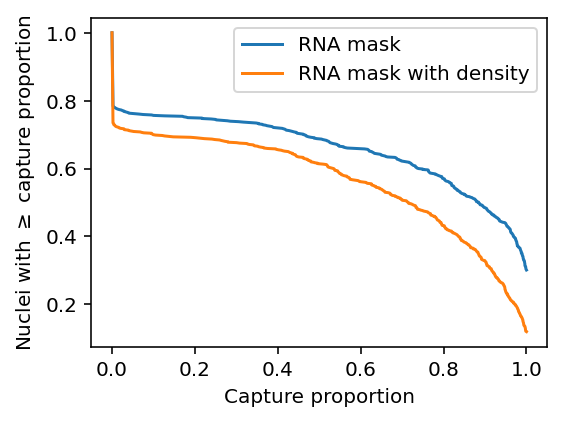

In [236]:
def capture_proportions(watershed, est_mask):
    labels = np.unique(watershed)[1:]
    props = []
    for label in labels:
        label_mask = watershed == label
        area = label_mask.sum()

        intersect = label_mask & est_mask
        intersect_area = intersect.sum()

        props.append(intersect_area / area)

    return np.unique(props, return_counts=True)

fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
unique, counts = capture_proportions(enlarged, est_enlarged_mask)
ax.plot(unique, np.cumsum(counts[::-1])[::-1] / counts.sum(), label='RNA mask')
ax.set_xlabel('Capture proportion')
ax.set_ylabel('Nuclei with $\geq$ capture proportion')

unique, counts = capture_proportions(enlarged, est_density_enlarged_mask)
ax.plot(unique, np.cumsum(counts[::-1])[::-1] / counts.sum(), label='RNA mask with density')
ax.legend()

Text(0.5, 1.0, 'RNA labels with density')

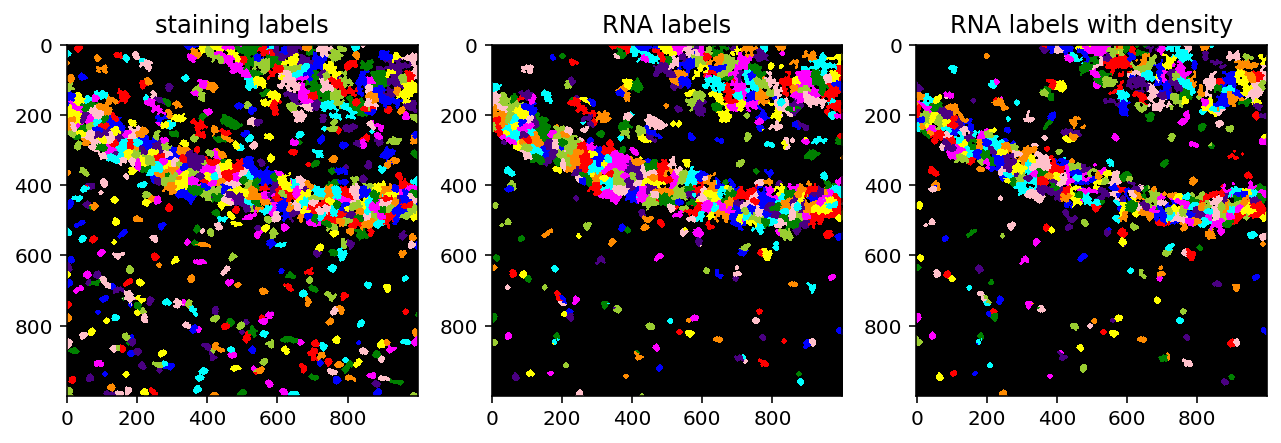

In [237]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)

axes[0].imshow(skimage.color.label2rgb(enlarged))
axes[0].set_title('staining labels')

axes[1].imshow(skimage.color.label2rgb(est_enlarged))
axes[1].set_title('RNA labels')

axes[2].imshow(skimage.color.label2rgb(est_density_enlarged))
axes[2].set_title('RNA labels with density')

Text(0.5, 1.0, 'w/ density ARS = 0.919')

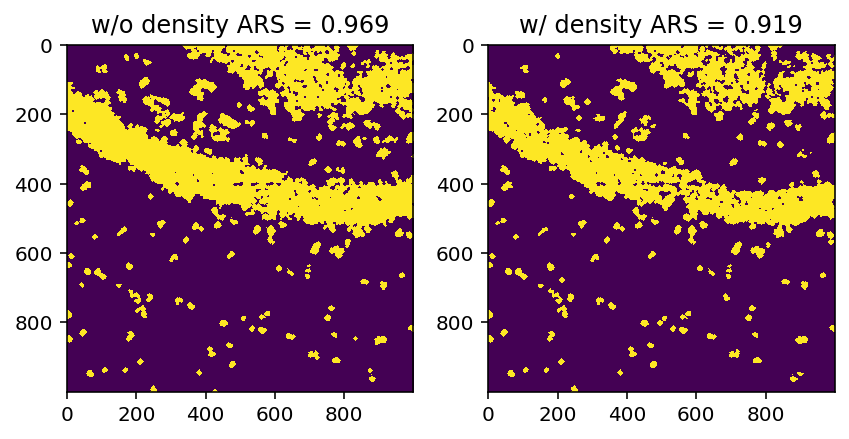

In [238]:
mask = (enlarged_mask) & (est_enlarged_mask)
ars = sklearn.metrics.adjusted_rand_score(
    enlarged.flatten()[mask.flatten()],
    est_enlarged.flatten()[mask.flatten()]
)
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(mask)
axes[0].set_title(f'w/o density ARS = {ars:.3f}')

mask = (enlarged_mask) & (est_density_enlarged_mask)
ars = sklearn.metrics.adjusted_rand_score(
    enlarged.flatten()[mask.flatten()],
    est_density_enlarged.flatten()[mask.flatten()]
)
axes[1].imshow(mask)
axes[1].set_title(f'w/ density ARS = {ars:.3f}')